<h1><center><font size="25">Reconocimiento facial con deep learning y python</font></center></h1>

<center><b>Joaquin Amat Rodrigo</b></center>

<center><i>Mayo, 2021 (Updated January 2025)</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

## Introducción

Los modelos de *deep learning* se han convertido en los modelos de referencia dentro de muchos ámbitos, uno de ellos, la visión artificial o visión por computación. Un ejemplo de aplicación cada vez más extendido es el del reconocimiento facial, es decir, la identificación automatizada de las personas presentes en una imagen o vídeo.

De forma similar a como hacemos los humanos, para que un sistema informático sea capaz de identificar a las personas que aparecen en una imagen, son necesarias varias etapas:

1. Detectar las caras en la imagen.

2. Utilizar una red neuronal capaz de mapear las características de una cara humana en una representación numérica. Este paso se conoce como *embedding* o *encoding*.

3. Medir la similitud entre la representación numérica de las caras detectadas y las representaciones de referencia disponibles en una base de datos.

4. Determinar si son suficientemente similares para considerar que pertenecen a la misma persona y asignarle la identidad.


A lo largo de este documento, se describen e implementan cada uno de los pasos haciendo uso de las librerías disponibles en **python**. Finalmente, se combinan todos ellos para crear un programa capaz de identificar a las personas presentes en una imagen, vídeo o webcam.

<div align="center">
<img src="./images/diagrama_face_recognition.png" style="width: 900px;">
</div>

<center><font size='2.5'> <i>Diagrama de los pasos seguidos en un sistema de reconocimiento facial.</i></font></center>

## Librerías

In [1]:
# Descarga y manipulación de datos
# ==============================================================================
import os
import numpy as np
from urllib.request import urlretrieve

# Manipulacion de imágenes
# ==============================================================================
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Modelos
# ==============================================================================
import torch
from facenet_pytorch import MTCNN , InceptionResnetV1
from scipy.spatial.distance import euclidean

## Imágenes



Para los ejemplos de este documento se utilizan imágenes de los actores de la divertida serie Modern Family. Como primer paso, se procede a descargar las imágenes en una carpeta local. Esto puede hacerse fácilmente desde python utilizando la función `urlretrieve` de la librería **urllib**.

In [2]:
# Descarga de imágenes
# ==============================================================================
if not os.path.exists('images'):
    os.makedirs('images')
# Imagen con una sola cara
url = ('https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/' +
       'raw/master/images/phil_dunphy.jpg')
urlretrieve(url=url, filename='images/imagen_1.jpg')

# Imagen con múltiples caras
url = ('https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
       'raw/master/images/modernfamily.jpg')
urlretrieve(url=url, filename='images/imagen_2.png');

Existen varias librerías que permiten tratar imágenes (lectura, escritura, redimensionamiento, recorte...) en python, tres de las más utilizadas son **OpenCV** (cv2), **PIL** y **matplotlib**. Es importante destacar que, OpenCV, utiliza el código de colores BGR mientras que PIL y matplotlib utilizan RGB. Afortunadamente, es sencillo intercambiar los formatos con las funciones `cv2.cvtColor(image, cv2.COLOR_BGR2RGB)` y `cv2.cvtColor(image, cv2.COLOR_RGB2BGR)`.

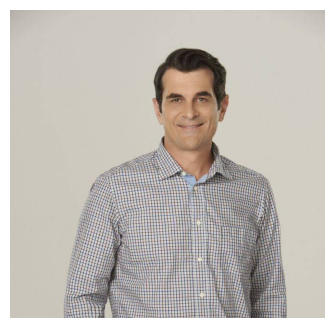

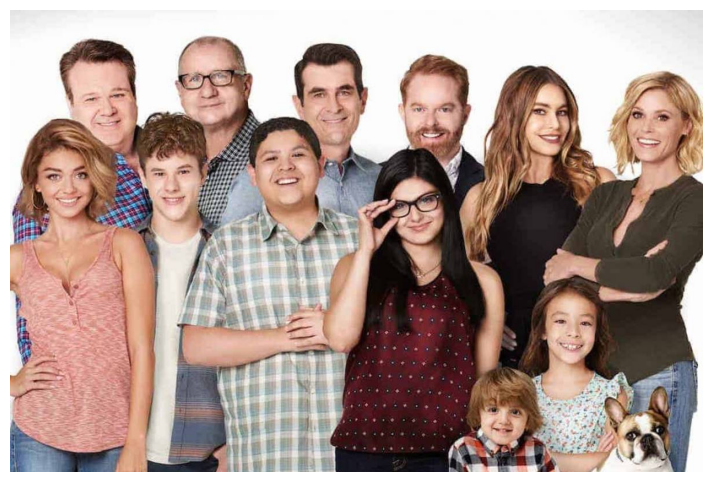

In [3]:
# Lectura de imágenes
# ==============================================================================
imagen_1 = Image.open('images/imagen_1.jpg')
imagen_2 = Image.open('images/imagen_2.png')

# imagen_1 = cv2.imread('images/imagen_1.jpg')
# imagen_2 = cv2.imread('images/imagen_2.png')

# Representación de imágenes
# ==============================================================================
plt.figure(figsize=(5, 4))
plt.imshow(imagen_1)
plt.axis('off');

plt.figure(figsize=(10, 6))
plt.imshow(imagen_2)
plt.axis('off');

## Detector de caras MTCNN



El primer paso en el proceso de reconocimiento facial es detectar dónde se encuentran las caras dentro de una imagen. Son muchas las estrategias y métodos de detección desarrollados desde que se iniciaran las primeras investigaciones en este campo (*histogram of oriented gradients (HOG)*, *Haar feature-based cascade*, *Single Shot Detector*...). Uno de los últimos, y que mejores resultados consigue, es el [*MultiTask Cascaded Convolutional Neural Network (MTCNN)*](https://arxiv.org/abs/1604.02878). Este detector está formado por la combinación de 3 modelos de redes neuronales que van refinando, de forma secuencial, las detecciones generadas. 
Existen varios detectores MTCNN para python, una de los más eficientes está implementado con [pytorch](https://pytorch.org/) y es accesible a través de la librería [facenet-pytorch](https://github.com/timesler/facenet-pytorch).

Su uso es sencillo, en primer lugar se instancia el modelo, cuyos principales parámetros son:

+ `image_size {int}`: tamaño de la imagen de salida en pixeles (el recorte de la cara detectada). Las imágenes son cuadradas. Por defecto, el tamaño es de 160x160 pixeles.

+ `thresholds {list}`: límites de detección para cada una de las tres redes que forman el detector MTCNN.

+ `margin {int}`: margen de pixeles añadido la bounding box (rectángulo que rodea la cara detectada).

+ `min_face_size {int}`: tamaño mínimo que ha de tener una cara para ser detectada.

+ `select_largest {bool}`: si `True`, en el caso de que se detecten múltiples caras, se devuelve la de mayor tamaño. Si `False`, se devuelve la de mayor probabilidad.

+ `keep_all {bool}`: si `True`, se devuelven todas las caras detectadas en la imagen, ordenadas acorde al criterio establecido por el argumento `select_largest`.

+ `post_process {bool}`: si se devuelve o no la imagen normalizada.

+ `device {torch.device}`: dónde se ejecuta el modelo. Puede ser: cpu, cuda, xpu, mkldnn, opengl, opencl, ideep, hip, msnpu, xla, vulkan.


Una vez creado el detector `MTCNN`, hay dos formas de aplicarlo. Con el método `forward()`, se devuelve un recorte de cada una de las caras detectadas. Con el método `detect()`, se devuelven las coordenadas de la *bounding box* de cada cara y, opcionalmente, los *landmarks* faciales.

In [4]:
# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            select_largest = False,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = True,
            image_size     = 160,
            device         = device
        )

Running on device: cpu


### Bounding boxes y landmarks faciales

Para que el modelo `MTCNN` devuelva las coordenadas donde se encuentran las caras, así como los *landmarks* faciales, se utiliza el método `detect()`. Esta es la información que se necesita si lo que se pretende es dibujar un recuadro (*bounding box*) sobre la imagen original.

El detector `MTCNN` acepta como entrada imágenes `PIL`  o `numpy.ndarray` 3D de tipo `uint8`. En el caso de disponer de múltiples imágenes, se puede pasar una lista de imágenes `PIL` o un batch en forma de `numpy.ndarray` 4D.

El resultado de la detección son 3 `numpy.ndarray`. Dentro de cada uno se encuentran:

+ Las coordenadas de la esquina superior-izquierda y la esquina inferior-derecha de cada *bounding box*.

+ Probabilidad de que cada *bounding box* contenga una cara.

+ Coordenadas de los ojos, nariz y comisura de la boca en cara cada detectada.

**Una cara por imagen**

In [5]:
# Detección de bounding box y landmarks
# ==============================================================================
boxes, probs, landmarks = mtcnn.detect(imagen_1, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

Bounding boxes: [[345.59942626953125 138.98275756835938 476.696044921875
  315.00347900390625]]
Probability: [0.9999898672103882]
landmarks: [[[383.51898193359375 209.4092254638672]
  [443.0420837402344 206.69790649414062]
  [417.0865478515625 243.09335327148438]
  [387.46636962890625 267.1329345703125]
  [445.9221496582031 265.30230712890625]]]


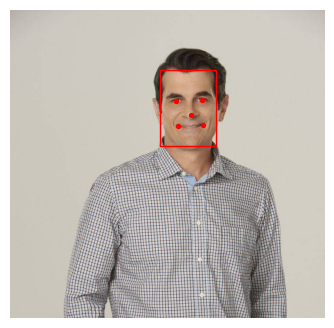

In [6]:
# Representación con matplotlib
# ==============================================================================
# En punto de origen (0,0) de una imagen es la esquina superior izquierda
for box, landmark in zip(boxes, landmarks):
     fig, ax  = plt.subplots(figsize=(5, 4))
     ax.imshow(imagen_1)
     ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
     rect = plt.Rectangle(
               xy     = (box[0], box[1]),
               width  = box[2] - box[0],
               height = box[3] - box[1],
               fill   = False,
               color  = 'red'
          )
     ax.add_patch(rect)
ax.axis('off');

**Múltiples caras por imágen**

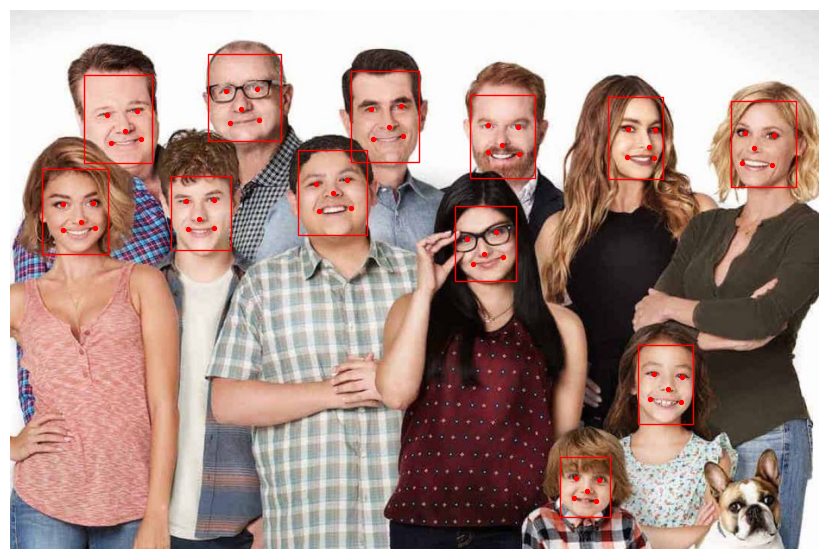

In [7]:
# Detección de bounding box y landmarks
# ==============================================================================
boxes, probs, landmarks = mtcnn.detect(imagen_2, landmarks=True)

# Representación con matplotlib
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(imagen_2)

for box, landmark in zip(boxes, landmarks):
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
    rect = plt.Rectangle(
                xy     = (box[0], box[1]),
                width  = box[2] - box[0],
                height = box[3] - box[1],
                fill   = False,
                color  = 'red'
           )
    ax.add_patch(rect)
    
ax.axis('off');

### Extracción de caras


Para extraer directamente las partes de la imagen que contienen caras, se utiliza el método `mtcnn(imagen)`. El objeto devuelto es un `tensor` con el valor de los pixeles del recorte (*3 canales color x image_size x image_size*). Si se detecta más de una cara (`keep_all=True`), entonces se devuelve un tensor de dimensiones (*nº caras x 3 canales color x image_size x image_size*).

**Una cara por imagen**

In [8]:
# Detección de cara
# ==============================================================================
face = mtcnn(imagen_1)
face

tensor([[[-0.5430, -0.6211, -0.5664,  ..., -0.6289, -0.6445, -0.6523],
         [-0.4727, -0.5977, -0.5742,  ..., -0.6523, -0.6523, -0.6680],
         [-0.6289, -0.4414, -0.4414,  ..., -0.6680, -0.6523, -0.6602],
         ...,
         [ 0.4883, -0.0273,  0.1602,  ..., -0.3867, -0.0664,  0.3711],
         [ 0.2617,  0.1289,  0.2852,  ..., -0.3711, -0.4883, -0.0820],
         [ 0.4961,  0.3398,  0.2539,  ...,  0.0352, -0.0664, -0.3008]],

        [[-0.5977, -0.6836, -0.6367,  ..., -0.6602, -0.6836, -0.7070],
         [-0.5273, -0.6680, -0.6445,  ..., -0.6758, -0.6758, -0.6836],
         [-0.6836, -0.5195, -0.5195,  ..., -0.6602, -0.6523, -0.6523],
         ...,
         [ 0.4805, -0.0430,  0.1445,  ..., -0.4805, -0.1602,  0.2852],
         [ 0.2539,  0.1211,  0.2852,  ..., -0.4648, -0.5820, -0.1602],
         [ 0.4883,  0.3398,  0.2539,  ..., -0.0586, -0.1602, -0.3789]],

        [[-0.6602, -0.7461, -0.6758,  ..., -0.7305, -0.7539, -0.7695],
         [-0.5898, -0.7070, -0.6836,  ..., -0

La imagen devuelta por el detector es un `tensor` con dimensiones [3, 160, 160], es decir, los canales de color están en primera posición. Para poder mostrar la imagen con *matplotlib*, hay que pasarlos a la última posición [160, 160, 3] y convertir de objeto tensor a `numpy array`.

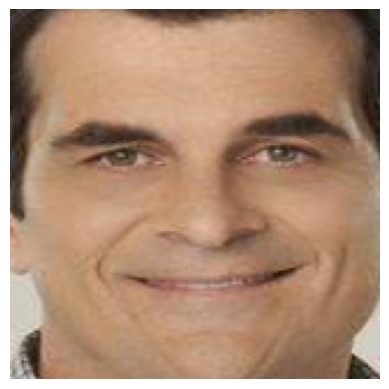

In [9]:
# Representación con matplotlib
# ==============================================================================
if face.min() < 0 or face.max() > 1:
    face = (face + 1) / 2  # Normalizar a [0, 1] si es necesario
    face = face.clamp(0, 1)  # Asegurar que los valores están en [0, 1]

face = face.permute(1, 2, 0)  # de [C, H, W] a [H, W, C]
plt.imshow(face)
plt.axis('off')
plt.show()

**Múltiples caras por imagen**

In [10]:
# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = True,
            image_size    = 160,
            device        = device
        )

# Detección de caras
# ==============================================================================
faces = mtcnn(imagen_2)

Al indicar `keep_all=True`, se devuelven todas las caras detectadas en la imagen. Las dimensiones del tensor generado son [nº caras, canales color, altura, anchura].

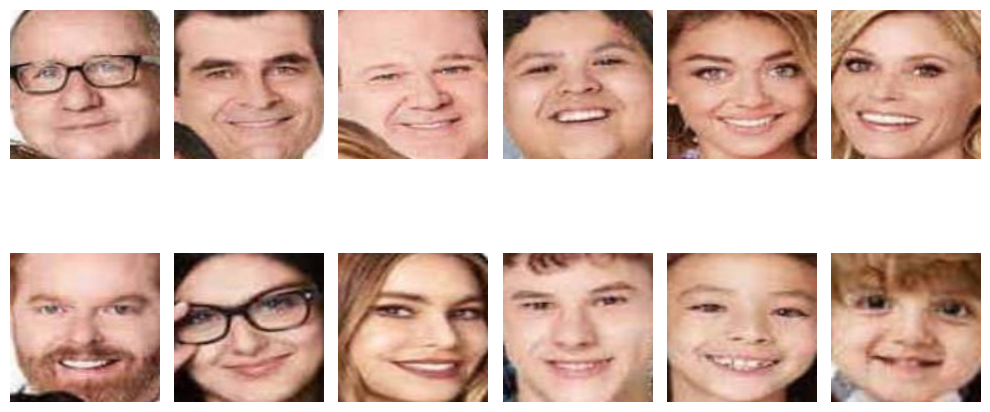

In [11]:
# Representación con matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(10, 6))
axs = axs.flatten()

for i in range(faces.shape[0]):
    face = faces[i].permute(1, 2, 0)      # [C,H,W] → [H,W,C]
    if face.min() < 0 or face.max() > 1:
        face = (face + 1) / 2  # Normalizar a [0, 1] si es necesario
        face = face.clamp(0, 1)  # Asegurar que los valores están en [0, 1]
    axs[i].imshow(face)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

El proceso de extracción también puede hacerse utilizando las coordenadas de las *bounding box*. La diferencia respecto a extraerlas directamente con el detector MTCNN es que, este último, hace un redimensionamiento para que la imagen devuelta sea cuadrada.

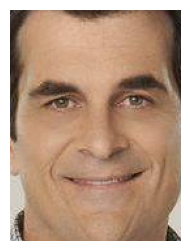

In [12]:
# Extracción de cara a partir de una bounding box
# ==============================================================================
boxes, probs, landmarks = mtcnn.detect(imagen_1, landmarks=True)
x1, y1, x2, y2 = boxes[0].astype(int)
recorte_cara = np.array(imagen_1)[y1:y2, x1:x2]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(recorte_cara)
plt.axis('off');

## Embedding de caras


Una vez identificadas las caras de la imagen, el siguiente paso consiste en obtener una transformación numérica que sea capaz de representar los aspectos característicos de cada una. Al vector numérico resultante se le conoce como *embedding* o *encoding*.

Los modelos de *deep learning* (redes convolucionales) que permiten obtener el *embedding* de caras no son sencillos de entrenar. Afortunadamente, existen varios modelos ya entrenados que son accesibles desde python. Dos de ellos son:

+ [face_recognition_model_v1](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) de la librería **dlib**. Este modelo genera un *embedding* de 128 valores.

+ [facenet_pytorch import InceptionResnetV1](https://github.com/timesler/facenet-pytorch) de la librería **facenet_pytorch**. Este modelo genera un *embedding* de 512 valores.

Para obtener este tipo de modelos, primero se entrena un modelo de clasificación con múltiples personas. Una vez entrenada la red, se elimina la última capa (*softmax*) para que la salida del modelo sea un vector numérico. En este documento se utiliza el modelo `InceptionResnetV1`, en concreto, la versión entrenada con el set de datos *vggface2*.  Para conocer más detalles sobre este tipo de modelos, es recomendable consultar la publicación [VGGFace2](https://arxiv.org/pdf/1710.08092.pdf).

<div align="center">
<img src="./images/diagrama_face_enbedding.png" style="width: 750px;">
</div>

<center><font size='2.5'> <i>Diagrama de un encoder (embedding) de un imagen.</i></font></center>

In [13]:
# Modelo para hacer el embedding de las caras
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
encoder = InceptionResnetV1(pretrained='vggface2', classify=False, device=device).eval().to(device)

# Detección de cara
# ==============================================================================
cara = mtcnn(imagen_1)
cara = cara.to(device)

# Embedding de cara
# ==============================================================================
with torch.no_grad():
    embedding_cara = encoder(cara).detach().cpu().squeeze()

embedding_cara

tensor([-5.9387e-02, -1.0320e-02, -4.9658e-02, -1.1456e-02, -3.7212e-02,
         4.1312e-02,  1.2151e-02,  1.8093e-02,  4.5636e-03, -1.7226e-02,
         1.9691e-02,  3.1572e-02,  1.1321e-02, -3.7982e-02,  7.0374e-02,
         1.9848e-02,  5.5991e-02, -6.9834e-02,  3.7653e-02, -3.6928e-02,
        -1.9657e-02,  4.9244e-02, -3.1942e-02, -2.1684e-02,  4.8117e-02,
        -4.1239e-02, -7.0518e-02,  3.6100e-02, -2.8826e-02,  7.4126e-02,
        -8.5627e-02,  5.3946e-03, -1.4197e-02,  1.1269e-02, -4.6381e-02,
        -4.0861e-02, -5.1269e-02, -9.5840e-03,  4.6257e-03, -1.3275e-02,
         7.4797e-02, -1.5688e-02, -3.1599e-02,  1.3980e-02, -2.2861e-02,
         1.1338e-02,  5.1907e-02, -3.3876e-02,  7.8948e-03, -7.2844e-03,
         3.3359e-02, -1.7969e-02,  7.7083e-03, -8.3847e-02,  5.2533e-02,
         2.2273e-02, -4.4366e-02,  7.6401e-03, -1.7525e-02,  6.6608e-02,
        -1.5720e-02,  3.1908e-02, -2.5368e-02, -3.6812e-02, -9.8693e-03,
         6.3684e-02,  1.2149e-02, -1.4021e-02, -5.8

## Similitud entre caras

El objetivo de obtener una representación numérica de las caras (*embeddings*) es poder cuantificar similitudes entre ellas. Dos formas de calcular esta similitud es utilizando la distancia euclídea o la distancia coseno entre *embeddings*. Cuanto menor es la distancia, mayor la similitud de las caras.

Véase el siguiente ejemplo en el que se compara una imagen frente a otras dos, la primera pertenece a la misma persona, Phil Dunphy, y la segunda a Cameron Tucker.

In [14]:
# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = True,
            image_size    = 160,
            device        = device
        )

In [15]:
# Extracción de las caras MTCNN
# ==============================================================================
phil_1 = mtcnn(imagen_1)[0]
phil_2 = mtcnn(imagen_2)[1]
cameron = mtcnn(imagen_2)[2]

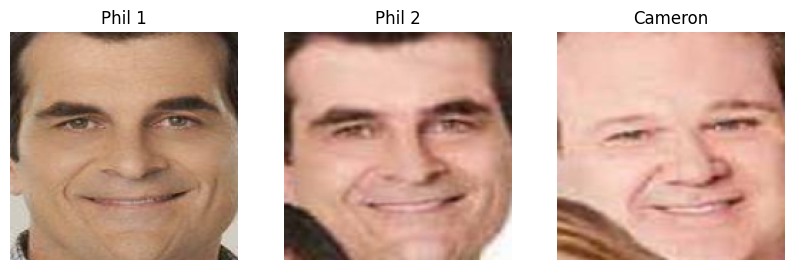

In [16]:
# Representación con matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

face = phil_1.permute(1, 2, 0)
face = (face + 1) / 2
axs[0].imshow(face)
axs[0].set_title('Phil 1')
axs[0].axis('off')

face = phil_2.permute(1, 2, 0)
face = (face + 1) / 2
axs[1].imshow(face)
axs[1].set_title('Phil 2')
axs[1].axis('off')

face = cameron.permute(1, 2, 0)
face = (face + 1) / 2
axs[2].imshow(face)
axs[2].set_title('Cameron')
axs[2].axis('off');

Una vez extraídas las 3 caras de las imágenes, se crean sus *embeddings* y se calcula la distancia euclídea entre ellas.

In [17]:
# Embeddings
# ==============================================================================
embeding_phil_1 = encoder(phil_1.reshape((1, 3, 160, 160))).detach().cpu().squeeze()
embeding_phil_2 = encoder(phil_2.reshape((1, 3, 160, 160))).detach().cpu().squeeze()
embeding_cameron = encoder(cameron.reshape((1, 3, 160, 160))).detach().cpu().squeeze()

In [18]:
embeding_phil_1

tensor([-5.9387e-02, -1.0320e-02, -4.9658e-02, -1.1456e-02, -3.7212e-02,
         4.1312e-02,  1.2151e-02,  1.8093e-02,  4.5636e-03, -1.7226e-02,
         1.9691e-02,  3.1572e-02,  1.1321e-02, -3.7982e-02,  7.0374e-02,
         1.9848e-02,  5.5991e-02, -6.9834e-02,  3.7653e-02, -3.6928e-02,
        -1.9657e-02,  4.9244e-02, -3.1942e-02, -2.1684e-02,  4.8117e-02,
        -4.1239e-02, -7.0518e-02,  3.6100e-02, -2.8826e-02,  7.4126e-02,
        -8.5627e-02,  5.3946e-03, -1.4197e-02,  1.1269e-02, -4.6381e-02,
        -4.0861e-02, -5.1269e-02, -9.5840e-03,  4.6257e-03, -1.3275e-02,
         7.4797e-02, -1.5688e-02, -3.1599e-02,  1.3980e-02, -2.2861e-02,
         1.1338e-02,  5.1907e-02, -3.3876e-02,  7.8948e-03, -7.2844e-03,
         3.3359e-02, -1.7969e-02,  7.7083e-03, -8.3847e-02,  5.2533e-02,
         2.2273e-02, -4.4366e-02,  7.6401e-03, -1.7525e-02,  6.6608e-02,
        -1.5720e-02,  3.1908e-02, -2.5368e-02, -3.6812e-02, -9.8693e-03,
         6.3684e-02,  1.2149e-02, -1.4021e-02, -5.8

In [19]:
# Distancias entre embeddings de caras
# ==============================================================================
print(f"Distancia entre la misma imagen Phil: {euclidean(embeding_phil_1, embeding_phil_1)}")
print(f"Distancia entre las dos imágenes de Phil: {euclidean(embeding_phil_1, embeding_phil_2)}")
print(f"Distancia entre Phil y Cameron: {euclidean(embeding_phil_1, embeding_cameron)}")

Distancia entre la misma imagen Phil: 0.0
Distancia entre las dos imágenes de Phil: 0.5903185606002808
Distancia entre Phil y Cameron: 1.388541340827942


Para poder identificar a quién pertenece una cara, es necesario contrastarla frente a una base de datos que contenga un *embedding* de referencia por cada identidad. Si no se dispone del vector de referencia de una identidad, esta no puede ser identificada.

## Pipeline de reconocimiento facial



En los apartados anteriores, se ha descrito de forma separada cada uno de los pasos que forman parte del proceso de reconocimiento facial. Sin embargo, para poder aplicarlo en un sistema real, es necesario combinarlos todos para que se ejecuten de forma secuencial. Con este objetivo, se definen una serie de funciones que permitan automatizar el proceso completo.


+ `pipeline_deteccion_imagen()`: detectar e identificar las personas de una imagen.

+ `pipeline_deteccion_video()`: detectar e identificar las personas de un vídeo.

+ `pipeline_deteccion_webcam()`: detectar e identificar las personas de un vídeo de entrada por webcam. Esta función requiere de abrir una ventana emergente de visualización, por lo que no puede utilizarse en google colab.

+ `crear_diccionario_referencias()`: crear un diccionario con los *embeddings* de referencia para cada persona.

### Código

In [ ]:
################################################################################
#                            RECONOCIMIENTO FACIAL                             #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution-NonCommercial-ShareAlike 4.0 International                       #
################################################################################
# coding=utf-8


# Librerías
# ==============================================================================
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import warnings
import typing
import logging
import os
import platform
import glob
import PIL
import facenet_pytorch
from typing import Union, Dict
from PIL import Image
from facenet_pytorch import MTCNN
from facenet_pytorch import InceptionResnetV1
from urllib.request import urlretrieve
from rich.progress import track
from scipy.spatial.distance import cosine, euclidean

warnings.filterwarnings('ignore')

logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.WARNING,
)


# Funciones para la detección, extracción, embedding, identificación y gráficos
# ==============================================================================
def detectar_caras(
        imagen: Union[PIL.Image.Image, np.ndarray],
        detector: facenet_pytorch.models.mtcnn.MTCNN = None,
        keep_all: bool                               = True,
        min_face_size: int                           = 20,
        thresholds: list                             = [0.6, 0.7, 0.7],
        device: str                                  = None,
        min_confidence: float                        = 0.5,
        fix_bbox: bool                               = True,
        verbose                                      = False
    ) -> np.ndarray:
    """
    Detectar la posición de caras en una imagen empleando un detector MTCNN.
    
    Parameters
    ----------
    imagen: PIL.Image, np.ndarray
        PIL Image o numpy array con la representación de la imagen.
    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
    keep_all: bool
        Default: True
        Si `True`, se devuelven todas las caras detectadas en la imagen.
    min_face_size : int
        Default: 20
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    device: str
        Default: None
        Device donde se ejecuta el modelo. Si el detector MTCNN, se pasa como
        argumento, no es necesario.
    min_confidence : float
        Default: 0.5
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.
    fix_bbox : bool
        Default: True
        Acota las dimensiones de las bounding box para que no excedan las
        dimensiones de la imagen. Esto evita problemas cuando se intenta
        representar las bounding box de caras que están en el margen de la
        imagen.
    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.
        
    Returns
    ----------
    numpy.ndarray
        Numpy array con las bounding box de cada cara detectada. Cada bounding
        box es a su vez una array formada por 4 valores que definen las coordenadas
        de la esquina superior-izquierda y la esquina inferior-derecha.
        
             (box[0],box[1])------------
                    |                  |
                    |                  |
                    |                  |
                    ------------(box[0],box[1])
                    
        Las bounding box devueltas por el detector ``MTCNN`` están definidas por
        valores de tipo `float`. Esto supone un problema para la posterior 
        representación con matplotlib, por lo que se convierten a tipo `int`.

    """
    
    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray, PIL.Image`. Recibido {type(imagen)}."
        )

    if detector is None:
        logging.info('Iniciando detector MTCC')
        detector = MTCNN(
                        keep_all      = keep_all,
                        min_face_size = min_face_size,
                        thresholds    = thresholds,
                        post_process  = True,
                        device        = device
                   )
        
    # Detección de caras
    # --------------------------------------------------------------------------
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32)
        
    bboxes, probs = detector.detect(imagen, landmarks=False)
    
    if bboxes is None:
        bboxes = np.array([])
        probs  = np.array([])
    else:
        # Se descartan caras con una probabilidad estimada inferior a `min_confidence`.
        bboxes = bboxes[probs > min_confidence]
        probs  = probs[probs > min_confidence]
        
    logging.info(f'Número total de caras detectadas: {len(bboxes)}')
    logging.info(f'Número final de caras seleccionadas: {len(bboxes)}')

    # Corregir bounding boxes
    # --------------------------------------------------------------------------
    # Si alguna de las esquinas de la bounding box está fuera de la imagen, se
    # corrigen para que no sobrepase los márgenes.
    if len(bboxes) > 0 and fix_bbox:       
        for i, bbox in enumerate(bboxes):
            if bbox[0] < 0:
                bboxes[i][0] = 0
            if bbox[1] < 0:
                bboxes[i][1] = 0
            if bbox[2] > imagen.shape[1]:
                bboxes[i][2] = imagen.shape[1]
            if bbox[3] > imagen.shape[0]:
                bboxes[i][3] = imagen.shape[0]

    # Información de proceso
    # ----------------------------------------------------------------------
    if verbose:
        print("----------------")
        print("Imagen escaneada")
        print("----------------")
        print(f"Caras detectadas: {len(bboxes)}")
        print(f"Correción bounding boxes: {ix_bbox}")
        print(f"Coordenadas bounding boxes: {bboxes}")
        print(f"Confianza bounding boxes:{probs} ")
        print("")
        
    return bboxes.astype(int)


def mostrar_bboxes(
        imagen: Union[PIL.Image.Image, np.ndarray],
        bboxes: np.ndarray,
        identidades: list = None,
        ax                = None
    ) -> None:
    """
    Mostrar la imagen original con las boundig box de las caras detectadas
    empleando matplotlib. Si pasa las identidades, se muestran sobre cada
    bounding box.

    Parameters
    ----------
    imagen: PIL.Image, np.ndarray
        `PIL Image` o `numpy array` con la representación de la imagen.
    bboxes: np.array
        Numpy array con las bounding box de las caras presentes en las imágenes.
        Cada bounding box es a su vez una array formada por 4 valores que definen
        las coordenadas de la esquina superior-izquierda y la esquina inferior-derecha.
        
             (box[0],box[1])------------
                    |                  |
                    |                  |
                    |                  |
                    ------------(box[2],box[3])           
    identidades: list
        Default: None
        Identidad asociada a cada bounding box. Debe tener el mismo número de
        elementos que `bboxes` y estar alineados de forma que `identidades[i]`
        se corresponde con `bboxes[i]`.
    ax: matplotlib.axes.Axes
        Default: None
        Axes de matplotlib sobre el que representar la imagen.
        
    Return
    ------
    None

    """
    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray, PIL.Image`. Recibido {type(imagen)}."
        )

    if identidades is not None:
        if len(bboxes) != len(identidades):
            raise Exception(
                '`identidades` debe tener el mismo número de elementos que `bboxes`.'
            )
    else:
        identidades = [None] * len(bboxes)

    # Mostrar la imagen y superponer bounding boxes
    # --------------------------------------------------------------------------
    if ax is None:
        ax = plt.gca()

    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32) / 255

    ax.imshow(imagen)
    ax.axis('off')

    if len(bboxes) > 0:

        for i, bbox in enumerate(bboxes):
            if identidades[i] is not None:
                rect = plt.Rectangle(
                            xy        = (bbox[0], bbox[1]),
                            width     = bbox[2] - bbox[0],
                            height    = bbox[3] - bbox[1],
                            linewidth = 1,
                            edgecolor = 'lime',
                            facecolor = 'none'
                        )

                ax.add_patch(rect)

                ax.text(
                    x = bbox[0],
                    y = bbox[1] - 10,
                    s = identidades[i],
                    fontsize = 10,
                    color    = 'lime'
                )
            else:
                rect = plt.Rectangle(
                            xy        = (bbox[0], bbox[1]),
                            width     = bbox[2] - bbox[0],
                            height    = bbox[3] - bbox[1],
                            linewidth = 1,
                            edgecolor = 'red',
                            facecolor = 'none'
                        )

                ax.add_patch(rect)

        plt.show()


def mostrar_bboxes_cv2(
    imagen: Union[PIL.Image.Image, np.ndarray],
    bboxes: np.ndarray,
    identidades: list = None,
    device: str       = "window",
) -> None:
    """
    Mostrar la imagen original con las boundig box de las caras detectadas
    empleando OpenCV. Si pasa las identidades, se muestran sobre cada
    bounding box. Esta función no puede utilizarse dentro de un Jupyter notebook.

    Parameters
    ----------
    imagen: PIL.Image, np.ndarray
        `PIL Image` o `numpy array` con la representación de la imagen.
    bboxes: np.array
        Numpy array con las bounding box de las caras presentes en las imágenes.
        Cada bounding box es a su vez una array formada por 4 valores que definen
        las coordenadas de la esquina superior-izquierda y la esquina inferior-derecha.
        
             (box[0],box[1])------------
                    |                  |
                    |                  |
                    |                  |
                    ------------(box[2],box[3])            
    identidades: list
        Default: None
        Identidad asociada a cada bounding box. Debe tener el mismo número de
        elementos que `bboxes` y estar alineados de forma que `identidades[i]`
        se corresponde con `bboxes[i]`.
    devide: str
        Default: 'window'
        Nombre de la ventana emergente que abre cv2.imshow(). Si `None`, se 
        devuelve la imagen pero no se muestra en ventana.
        
    Return
    ------
    None

    """

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray`, `PIL.Image`. Recibido {type(imagen)}."
        )

    if identidades is not None:
        if len(bboxes) != len(identidades):
            raise Exception(
                '`identidades` debe tener el mismo número de elementos que `bboxes`.'
            )
    else:
        identidades = [None] * len(bboxes)

    # Mostrar la imagen y superponer bounding boxes
    # --------------------------------------------------------------------------
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32) / 255

    if len(bboxes) > 0:

        for i, bbox in enumerate(bboxes):

            if identidades[i] is not None:
                cv2.rectangle(
                    img       = imagen,
                    pt1       = (bbox[0], bbox[1]),
                    pt2       = (bbox[2], bbox[3]),
                    color     = (0, 255, 0),
                    thickness = 2
                )

                cv2.putText(
                    img       = imagen, 
                    text      = identidades[i], 
                    org       = (bbox[0], bbox[1]-10), 
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale = 1e-3 * imagen.shape[0],
                    color     = (0, 255, 0),
                    thickness = 2
                )
            else:
                cv2.rectangle(
                    img       = imagen,
                    pt1       = (bbox[0], bbox[1]),
                    pt2       = (bbox[2], bbox[3]),
                    color     = (255, 0, 0),
                    thickness = 2
                )

    if device is None:
        return imagen
    else:
        cv2.imshow(device, cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(1) == 27: 
            cv2.destroyAllWindows()  # esc para cerrar la ventana


def extraer_caras(
    imagen: Union[PIL.Image.Image, np.ndarray],
    bboxes: np.ndarray,
    output_img_size: Union[list, tuple, np.ndarray] = [160, 160],
) -> None:
    """
    Extraer las zonas de una imagen contenidas en bounding boxes.

    Parameters
    ----------
    imagen: PIL.Image, np.ndarray
        PIL Image o numpy array con la representación de la imagen.
    bboxes: np.array
        Numpy array con las bounding box de las caras presentes en las imágenes.
        Cada bounding box es a su vez una array formada por 4 valores que definen
        las coordenadas de la esquina superior-izquierda y la esquina inferior-derecha.
        
             (box[0],box[1])------------
                    |                  |
                    |                  |
                    |                  |
                    ------------(box[2],box[3])              
    output_img_size: list, tuple, np.ndarray
        Default: [160, 160]
        Tamaño de las imágenes de salida en pixels.
        
    Return
    ------
    np.ndarray, shape=[len(bboxes), output_img_size[0], output_img_size[1], 3]

    """
    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser np.ndarray, PIL.Image. Recibido {type(imagen)}."
        )

    # Recorte de cara
    # --------------------------------------------------------------------------
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen)

    if len(bboxes) > 0:
        caras = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            cara = imagen[y1:y2, x1:x2]
            # Redimensionamiento del recorte
            cara = Image.fromarray(cara)
            cara = cara.resize(tuple(output_img_size))
            cara = np.array(cara)
            caras.append(cara)

    caras = np.stack(caras, axis=0)

    return caras


def calcular_embeddings(
    img_caras: np.ndarray, encoder=None, device: str = None
) -> np.ndarray:
    """
    Caclular el embedding (encoding) de caras utilizando el modelo InceptionResnetV1
    de la librería facenet_pytorch. 

    Parameters
    ----------
    img_caras: np.ndarray, shape=[nº caras, ancho, alto, 3]
        Imágenes que representan las caras.
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumeto.
    device: str
        Default: None
        Device donde se ejecuta el modelo. Si el encoder, se pasa como argumento,
        no es necesario.
        
    Return
    ------
    np.ndarray, shape=[nº caras, 512]

    """

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(img_caras, np.ndarray):
        raise Exception(
            f"`img_caras` debe ser np.ndarray {type(img_caras)}."
        )

    if img_caras.ndim != 4:
        raise Exception(
            f"`img_caras` debe ser np.ndarray con dimensiones [nº caras, ancho, alto, 3]."
            f" Recibido {img_caras.ndim}."
        )

    if encoder is None:
        logging.info('Iniciando encoder InceptionResnetV1')
        encoder = InceptionResnetV1(
                        pretrained = 'vggface2',
                        classify   = False,
                        device     = device
                   ).eval()

    # Calculo de embedings
    # --------------------------------------------------------------------------
    # El InceptionResnetV1 modelo requiere que las dimensiones de entrada sean
    # [nº caras, 3, ancho, alto]
    caras = np.moveaxis(img_caras, -1, 1)
    caras = caras.astype(np.float32) / 255
    caras = torch.tensor(caras)
    embeddings = encoder.forward(caras).detach().cpu().numpy()
    embeddings = embeddings.squeeze()
    return embeddings


def identificar_caras(
    embeddings: np.ndarray, dic_referencia: dict, threshold_similaridad: float = 0.6
) -> list:
    """
    Dado un conjunto de nuevos embeddings y un diccionario con de referencia,
    se calcula la similitud entre cada nuevo embedding y los embeddings de
    referencias.  Si la similitud supera un determinado threshold se devuelve la
    identidad de la persona.


    Parameters
    ----------
    embeddings: np.ndarray, shape=[nº caras, 512]
        Embeddings de las caras que se quieren identificar.
    dic_referencia: dict
        Diccionario utilizado como valores de referencia. La clave representa
        la identidad de la persona y el valor el embedding de su cara. 
    threshold_similaridad: float
        Default: 0.6
        Similitud mínima que tiene que haber entre embeddings para que se le
        asigne la identidad. De lo contrario se le asigna la etiqueta de "desconocido".
        
    Return
    ------
    list, len=nº caras
    """

    identidades = []
    for i in range(embeddings.shape[0]):
        # Se calcula la similitud con cada uno de los perfiles de referencia.
        similitudes = {}
        for key, value in dic_referencia.items():
            similitudes[key] = 1 - cosine(embeddings[i], value)

        # Se identifica la persona de mayor similitud.
        identidad = max(similitudes, key=similitudes.get)
        # Si la similitud < threshold_similaridad, se etiqueta como None
        if similitudes[identidad] < threshold_similaridad:
            identidad = None

        identidades.append(identidad)

    return identidades


def crear_diccionario_referencias(
    folder_path: str,
    dic_referencia: dict = None,
    detector: facenet_pytorch.models.mtcnn.MTCNN = None,
    min_face_size: int = 40,
    thresholds: list = [0.6, 0.7, 0.7],
    min_confidence: float = 0.9,
    encoder=None,
    device: str = None,
    verbose: bool = False,
) -> dict:
    """
    Crea o actualiza un diccionario con los embeddings de referencia de personas.

    Parameters
    ----------
    folder_path: str
        Path al directorio con las imágenes de referencia. La estructura esperada
        en este directorio es:
        
            - Una carpeta por cada identidad. El nombre de la carpeta se utiliza
              como identificador único.
            - Dentro de cada carpeta puede haber una o más imágenes de la persona.
              Si hay más de una se calcula el embedding promedio de todas ellas.
              En las imágenes de referencia solo puede aparecer la cara de la 
              persona en cuestión.
    dic_referencia: dict 
        Default: None
        Diccionario de referencia previamente creado. Se actualiza con las nuevas
        identidades. En el caso de identidades ya existentes, se actualizan con
        los nuevos embeddings.
    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
    min_face_size : int
        Default: 40
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    min_confidence : float
        Default: 0.9
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumento.
    device: str
        Default: None
        Device donde se ejecutan los modelos de detección y embedding. Ignorado
        si el encoder o el detector han sido inicializados con anterioridad.
    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.
        
    Return
    ------
    dict
        Diccionario con los embeddings de referencia. La clave representa la
        identidad de la persona y el valor el embedding de su cara.

    """
    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not os.path.isdir(folder_path):
        raise Exception(
            f"Directorio {folder_path} no existe."
        )

    if len(os.listdir(folder_path) ) == 0:
        raise Exception(
            f"Directorio {folder_path} está vacío."
        )

    if detector is None:
        logging.info('Iniciando detector MTCC')
        detector = MTCNN(
                        keep_all      = False,
                        post_process  = False,
                        min_face_size = min_face_size,
                        thresholds    = thresholds,
                        device        = device
                   )

    if encoder is None:
        logging.info('Iniciando encoder InceptionResnetV1')
        encoder = InceptionResnetV1(
                        pretrained = 'vggface2',
                        classify   = False,
                        device     = device
                   ).eval()

    new_dic_referencia = {}
    folders = glob.glob(folder_path + "/*")

    for folder in folders:

        if platform.system() in ['Linux', 'Darwin']:
            identidad = folder.split("/")[-1]
        else:
            identidad = folder.split("\\")[-1]

        logging.info(f'Obteniendo embeddings de: {identidad}')
        embeddings = []
        # Se lista todas las imagenes .jpg .jpeg .tif .png
        path_imagenes = glob.glob(folder + "/*.jpg")
        path_imagenes.extend(glob.glob(folder + "/*.jpeg"))
        path_imagenes.extend(glob.glob(folder + "/*.tif"))
        path_imagenes.extend(glob.glob(folder + "/*.png"))
        logging.info(f'Total imagenes referencia: {len(path_imagenes)}')

        for path_imagen in path_imagenes:
            logging.info(f'Leyendo imagen: {path_imagen}')
            imagen = Image.open(path_imagen)
            # Si la imagen es RGBA se pasa a RGB
            if np.array(imagen).shape[2] == 4:
                imagen  = np.array(imagen)[:, :, :3]
                imagen  = Image.fromarray(imagen)

            bbox = detectar_caras(
                        imagen,
                        detector       = detector,
                        min_confidence = min_confidence,
                        verbose        = False
                    )

            if len(bbox) > 1:
                logging.warning(
                    f'Más de 2 caras detectadas en la imagen: {path_imagen}. '
                    f'Se descarta la imagen del diccionario de referencia.'
                )
                continue

            if len(bbox) == 0:
                logging.warning(
                    f'No se han detectado caras en la imagen: {path_imagen}.'
                )
                continue

            cara = extraer_caras(imagen, bbox)
            embedding = calcular_embeddings(cara, encoder=encoder)
            embeddings.append(embedding)

        if verbose:
            print(f"Identidad: {identidad} --- Imágenes referencia: {len(embeddings)}")

        embedding_promedio = np.array(embeddings).mean(axis = 0)
        new_dic_referencia[identidad] = embedding_promedio

    if dic_referencia is not None:
        dic_referencia.update(new_dic_referencia)
        return dic_referencia
    else:
        return new_dic_referencia


def pipeline_deteccion_imagen(
    imagen: Union[PIL.Image.Image, np.ndarray],
    dic_referencia: dict,
    detector: facenet_pytorch.models.mtcnn.MTCNN = None,
    keep_all: bool = True,
    min_face_size: int = 20,
    thresholds: list = [0.6, 0.7, 0.7],
    device: str = None,
    min_confidence: float = 0.5,
    fix_bbox: bool = True,
    output_img_size: Union[list, tuple, np.ndarray] = [160, 160],
    encoder=None,
    threshold_similaridad: float = 0.5,
    ax=None,
    verbose=False,
) -> None:

    """
    Detección e identificación de las personas que aparecen en una imagen.
    

    Parameters
    ----------
    imagen: PIL.Image, np.ndarray
        PIL Image o numpy array con la representación de la imagen.
    dic_referencia: dict 
        Diccionario con los embeddings de referencia.
    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
    keep_all: bool
        Default: True
        Si `True`, se devuelven todas las caras detectadas en la imagen.
    min_face_size : int
        Default: 20
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    device: str
        Default: None
        Device donde se ejecutan los modelos de detección y embedding. Ignorado
        si el encoder o el detector han sido inicializados con anterioridad.
    min_confidence : float
        Default: 0.5
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.
    fix_bbox : bool
        Default: True
        Acota las dimensiones de las bounding box para que no excedan las
        dimensiones de la imagen. Esto evita problemas cuando se intenta
        representar las bounding box de caras que están en el margen de la
        imagen.
    output_img_size: list, tuple, np.ndarray
        Default: [160, 160]
        Tamaño de las imágenes de salida en pixels.
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumento.
    threshold_similaridad: float
        Default: 0.5
        Similitud mínima que tiene que haber entre embeddings para que se le
        asigne la identidad. De lo contrario se le asigna la etiqueta de "desconocido".
    ax: matplotlib.axes.Axes
        Default: None
        Axes de matplotlib sobre el que representar la imagen.
    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.

    Return
    ------
    None
    
    """

    bboxes = detectar_caras(
                imagen         = imagen,
                detector       = detector,
                keep_all       = keep_all,
                min_face_size  = min_face_size,
                thresholds     = thresholds,
                device         = device,
                min_confidence = min_confidence,
                fix_bbox       = fix_bbox
              )

    if len(bboxes) == 0:

        logging.info('No se han detectado caras en la imagen.')
        mostrar_bboxes(
            imagen      = imagen,
            bboxes      = bboxes,
            ax          = ax
        )

    else:

        caras = extraer_caras(
                    imagen = imagen,
                    bboxes = bboxes
                )

        embeddings = calcular_embeddings(
                        img_caras = caras,
                        encoder   = encoder
                     )

        identidades = identificar_caras(
                         embeddings            = embeddings,
                         dic_referencia        = dic_referencia,
                         threshold_similaridad = threshold_similaridad
                       )

        mostrar_bboxes(
            imagen      = imagen,
            bboxes      = bboxes,
            identidades = identidades,
            ax          = ax
        )


def pipeline_deteccion_video(
    path_input_video: str,
    dic_referencia: dict,
    path_output_video: str = os.getcwd(),
    detector: facenet_pytorch.models.mtcnn.MTCNN = None,
    keep_all: bool = True,
    min_face_size: int = 40,
    thresholds: list = [0.6, 0.7, 0.7],
    device: str = None,
    min_confidence: float = 0.5,
    fix_bbox: bool = True,
    output_img_size: Union[list, tuple, np.ndarray] = [160, 160],
    encoder=None,
    threshold_similaridad: float = 0.5,
    ax=None,
    verbose=False,
) -> None:

    """
    Detección e identificación de las personas que aparecen en un vídeo. El
    resultado se escribe en una ruta especificada por el usuario.
    

    Parameters
    ----------
    path_input_video: str
        Path completo al vídeo que se quiere procesar
    dic_referencia: dict 
        Diccionario con los embeddings de referencia.
    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
    keep_all: bool
        Default: True
        Si `True`, se devuelven todas las caras detectadas en la imagen.
    min_face_size : int
        Default: 20
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    device: str
        Default: None
        Device donde se ejecutan los modelos de detección y embedding. Ignorado
        si el encoder o el detector han sido inicializados con anterioridad.
    min_confidence : float
        Default: 0.5
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.
    fix_bbox : bool
        Default: True
        Acota las dimensiones de las bounding box para que no excedan las
        dimensiones de la imagen. Esto evita problemas cuando se intenta
        representar las bounding box de caras que están en el margen de la
        imagen.
    output_img_size: list, tuple, np.ndarray
        Default: [160, 160]
        Tamaño de las imágenes de salida en pixels.
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumento.
    threshold_similaridad: float
        Default: 0.6
        Similitud mínima que tiene que haber entre embeddings para que se le
        asigne la identidad. De lo contrario se le asigna la etiqueta de "desconocido".
    ax: matplotlib.axes.Axes
        Default: None
        Axes de matplotlib sobre el que representar la imagen.
    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.

    Return
    ------
    None
    
    """

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not os.path.isfile(path_input_video):
        raise Exception(
            f"El archivo {path_input_video} no existe."
        )

    capture = cv2.VideoCapture(path_input_video)
    input_frames = []
    output_frames = []

    frame_exist = True
    while (frame_exist):
        frame_exist, frame = capture.read()

        if not frame_exist:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_frames.append(frame)
    capture.release()

    for frame in track(input_frames, description="Procesando frames del vídeo"):

        bboxes = detectar_caras(
                        imagen         = frame,
                        detector       = detector,
                        keep_all       = keep_all,
                        min_face_size  = min_face_size,
                        thresholds     = thresholds,
                        device         = device,
                        min_confidence = min_confidence,
                        fix_bbox       = fix_bbox
                      )

        if len(bboxes) == 0:

            logging.info('No se han detectado caras en la imagen.')

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                device      = None
                             )
            output_frames.append(frame_procesado)

        else:

            caras = extraer_caras(
                        imagen = frame,
                        bboxes = bboxes
                    )

            embeddings = calcular_embeddings(
                            img_caras = caras,
                            encoder   = encoder
                         )

            identidades = identificar_caras(
                             embeddings     = embeddings,
                             dic_referencia = dic_referencia,
                             threshold_similaridad = threshold_similaridad
                          )

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                identidades = identidades,
                                device = None
                             )
            output_frames.append(frame_procesado)

    if len(output_frames) > 0:
        frame_size = (output_frames[0].shape[1], output_frames[0].shape[0])
        # out = cv2.VideoWriter('test.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, frame_size)
        # out = cv2.VideoWriter(path_output_video, 0x7634706d, 25, frame_size)
        out = cv2.VideoWriter(path_output_video, cv2.VideoWriter_fourcc(*'MP4V'), 25, frame_size)

        for frame in output_frames:
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        out.release()

    return


def pipeline_deteccion_webcam(
    dic_referencia: dict,
    output_device: str = "window",
    path_output_video: str = os.getcwd(),
    detector: facenet_pytorch.models.mtcnn.MTCNN = None,
    keep_all: bool = True,
    min_face_size: int = 40,
    thresholds: list = [0.6, 0.7, 0.7],
    device: str = None,
    min_confidence: float = 0.5,
    fix_bbox: bool = True,
    output_img_size: Union[list, tuple, np.ndarray] = [160, 160],
    encoder=None,
    threshold_similaridad: float = 0.5,
    ax=None,
    verbose=False,
) -> None:

    """
    Detección e identificación de las personas que aparecen en el vídeo de webcam.
    
    Parameters
    ----------
    output_device: str
        Nombre de la ventana emergente que abre cv2.imshow()
    dic_referencia: dict 
        Diccionario con los embeddings de referencia.
    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
    keep_all: bool
        Default: True
        Si `True`, se devuelven todas las caras detectadas en la imagen.
    min_face_size : int
        Default: 20
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    device: str
        Default: None
        Device donde se ejecutan los modelos de detección y embedding. Ignorado
        si el encoder o el detector han sido inicializados con anterioridad.
    min_confidence : float
        Default: 0.5
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.
    fix_bbox : bool
        Default: True
        Acota las dimensiones de las bounding box para que no excedan las
        dimensiones de la imagen. Esto evita problemas cuando se intenta
        representar las bounding box de caras que están en el margen de la
        imagen.
    output_img_size: list, tuple, np.ndarray
        Default: [160, 160]
        Tamaño de las imágenes de salida en pixels.
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumento.
    threshold_similaridad: float
        Default: 0.6
        Similitud mínima que tiene que haber entre embeddings para que se le
        asigne la identidad. De lo contrario se le asigna la etiqueta de "desconocido".
    ax: matplotlib.axes.Axes
        Default: None
        Axes de matplotlib sobre el que representar la imagen.
    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.

    Return
    ------
    None
    
    """
    capture = cv2.VideoCapture(0)
    frame_exist = True

    while (frame_exist):
        frame_exist, frame = capture.read()

        if not frame_exist:
            capture.release()
            cv2.destroyAllWindows()
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        bboxes = detectar_caras(
                        imagen         = frame,
                        detector       = detector,
                        keep_all       = keep_all,
                        min_face_size  = min_face_size,
                        thresholds     = thresholds,
                        device         = device,
                        min_confidence = min_confidence,
                        fix_bbox       = fix_bbox
                      )

        if len(bboxes) == 0:

            logging.info('No se han detectado caras en la imagen.')
            cv2.imshow(output_device, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        else:

            caras = extraer_caras(
                        imagen = frame,
                        bboxes = bboxes
                    )

            embeddings = calcular_embeddings(
                            img_caras = caras,
                            encoder   = encoder
                         )

            identidades = identificar_caras(
                             embeddings     = embeddings,
                             dic_referencia = dic_referencia,
                             threshold_similaridad = threshold_similaridad
                          )

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                identidades = identidades,
                                device = output_device
                             )

        if cv2.waitKey(1) == 27: 
            break  # esc para cerrar la ventana

    capture.release()
    cv2.destroyAllWindows()

### Creación del diccionario de referencias

In [28]:
# Descarga de las imágenes de referencia
# ==============================================================================
import urllib
import zipfile

url = ('https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
       'raw/master/images/imagenes_referencia_reconocimiento_facial.zip')

extract_dir = './images/imagenes_referencia_reconocimiento_facial'

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [29]:
# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(F'Running on device: {device}')

# Crear diccionario de referencia para cada persona
# ==============================================================================
dic_referencias = crear_diccionario_referencias(
                    folder_path    = './images/imagenes_referencia_reconocimiento_facial',
                    min_face_size  = 40,
                    min_confidence = 0.9,
                    device         = device,
                    verbose        = True
                  )

Running on device: cpu
Identidad: JayPritchett --- Imágenes referencia: 2
Identidad: AlexDunphy --- Imágenes referencia: 3
Identidad: CameronTucker --- Imágenes referencia: 2
Identidad: JoePritchett --- Imágenes referencia: 5
Identidad: MitchellPritchett --- Imágenes referencia: 3
Identidad: HaleyDunphy --- Imágenes referencia: 4
Identidad: PhilDunphy --- Imágenes referencia: 4
Identidad: MannyDelgado --- Imágenes referencia: 6
Identidad: LilyTucker-Pritchett --- Imágenes referencia: 4
Identidad: ClaireDunphy --- Imágenes referencia: 3
Identidad: GloriaPritchett --- Imágenes referencia: 3
Identidad: LukeDunphy --- Imágenes referencia: 4


### Reconocimiento en imágenes

Running on device: cpu


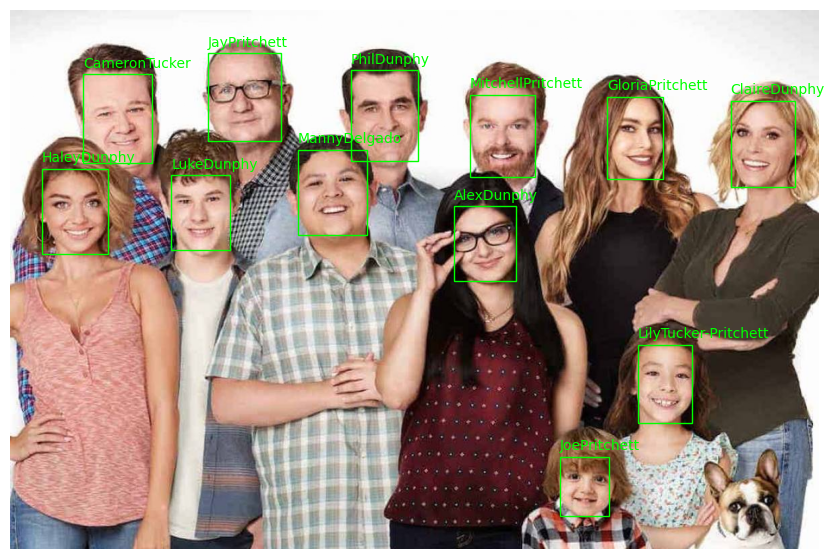

In [30]:
# Reconocimiento en imágenes
# ==============================================================================
# Detectar si se dispone de GPU cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(F'Running on device: {device}')

# Identificar las personas en la imagen
fig, ax = plt.subplots(figsize=(12, 7))
imagen = Image.open('images/imagen_2.png')

pipeline_deteccion_imagen(
    imagen                = imagen,
    dic_referencia        = dic_referencias,
    min_face_size         = 20,
    thresholds            = [0.6, 0.7, 0.7],
    min_confidence        = 0.5,
    threshold_similaridad = 0.5,
    device                = device,
    ax                    = ax,
    verbose               = False
)

### Reconocimiento en vídeo



A diferencia de `pipeline_deteccion_imagen()`, la función `pipeline_deteccion_video()` no recibe como entrada directamente el vídeo, sino la ruta de su localización. Una vez procesado el vídeo, se escribe de nuevo la salida en disco.

El procesamiento de vídeo requiere procesar cada uno de sus *frames*, por lo que es computacionalmente muy costoso. Se recomienda utilizar GPUs.

El vídeo utilizado para este ejemplo puede descargarse del siguiente [link](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/raw/master/images/video_modern_family.mp4).

In [25]:
# Reconocimiento en vídeo
# ==============================================================================
pipeline_deteccion_video(
    path_input_video      = 'videos/video_modern_family.mp4',
    path_output_video     = 'videos/video_processed.mp4',
    dic_referencia        = dic_referencias,
    threshold_similaridad = 0.4,
)

KeyboardInterrupt: 

<div>
<img src='./videos/video_processed.gif' width="500"/>
</div>

### Reconocimiento en webcam



`pipeline_deteccion_webcam()` requiere abrir una ventana emergente de visualización, por lo que no puede utilizarse en google colab.
<br><br>


In [ ]:
# pipeline_deteccion_webcam(
#     dic_referencia        = dic_referencias,
#     threshold_similaridad = 0.4,
# )

## Información de sesión

In [ ]:
import session_info
session_info.show(html=False)

-----
PIL                 10.4.0
cv2                 4.10.0
facenet_pytorch     NA
matplotlib          3.9.2
numpy               1.26.0
scipy               1.14.1
session_info        1.0.0
torch               2.2.2+cu121
tqdm                4.66.5
-----
IPython             8.27.0
jupyter_client      8.6.3
jupyter_core        5.7.2
notebook            6.4.12
-----
Python 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:27:27) [GCC 11.2.0]
Linux-5.15.0-1073-aws-x86_64-with-glibc2.31
-----
Session information updated at 2025-01-07 11:29


## Bibliografía

Deep Learning by Josh Patterson, Adam Gibson

Python Machine Learning 3rd Edition by Sebastian Raschka

Hands-On Computer Vision with TensorFlow 2 by Benjamin Planche and Eliot Andres

https://github.com/timesler/facenet-pytorch

## Instrucciones para citar


**¿Cómo citar este documento?**

Si utilizas este documento o alguna parte de él, te agradecemos que lo cites. ¡Muchas gracias!

<p style="text-align:left"><font size="3" color="#555">
Reconocimiento facial con deep learning y python por Joaquín Amat Rodrigo, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py34-reconocimiento-facial-deeplearning-python.html
</font></p>

<strong>¿Te ha gustado el artículo? Tu ayuda es importante</strong>

Tu contribución me ayudará a seguir generando contenido divulgativo gratuito. ¡Muchísimas gracias! &#128522;

<a href="https://www.paypal.com/donate?token=qGvuu_W8hDgHIwyUCo5CZfFt7gXQZ_hGFIlKtLVYdO2p56fIAlrHdS1Nsjqbc9AmL0owCFv0mUgM93yF"><img src="https://www.paypalobjects.com/en_US/ES/i/btn/btn_donateCC_LG.gif" style="text-align: center"/></a>


<a href="https://github.com/sponsors/JoaquinAmatRodrigo" target="_blank" title="Become a GitHub Sponsor">
<img style="margin-bottom: 1em; max-width: 200px;" src="../images/github_sponsor_button.png" alt="Become a GitHub Sponsor" style="text-align: center"> </a>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-nc-sa.svg" /></a><br/>

Este documento creado por Joaquín Amat Rodrigo tiene licencia <a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Attribution-NonCommercial-ShareAlike 4.0 International</a>.

<p style="text-align:left"><font size="3" color="#555">Se permite:</font></p>

<ul>
<li>
  <p style="text-align:left"><font size="3" color="#555">Compartir: copiar y redistribuir el material en cualquier medio o formato.</font></p>
</li>
<li>
  <p style="text-align:left"><font size="3" color="#555">Adaptar: remezclar, transformar y crear a partir del material.</font></p>
</li>
</ul>

<p style="text-align:left"><font size="3" color="#555">Bajo los siguientes términos:</font></p>

<ul>
<li>
  <p style="text-align:left"><font size="3" color="#555">Atribución: Debes otorgar <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es#ref-appropriate-credit">el crédito adecuado</a>, proporcionar un enlace a la licencia e <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es#ref-indicate-changes">indicar si se realizaron cambios</a>. Puedes hacerlo de cualquier manera razonable, pero no de una forma que sugiera que el licenciante te respalda o respalda tu uso.</font></p>
</li>

<li>
  <p style="text-align:left"><font size="3" color="#555">No-Comercial: No puedes utilizar el material para <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es#ref-commercial-purposes">fines comerciales</a>.</font></p>
</li>

<li>
  <p style="text-align:left"><font size="3" color="#555">Compartir-Igual: Si remezclas, transformas o creas a partir del material, debes distribuir tus contribuciones bajo la <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es#ref-same-license">misma licencia</a> que el original.</font></p>
</li>
</ul>

In [ ]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans', 'Helvetica Neue', Helvetica, Arial, sans-serif;
    font-size: 16px; 
    line-height: 1.6;
    font-weight: 400;
    text-shadow: none;
    color: #2c2c2c;
    text-rendering: optimizeLegibility;
    letter-spacing: 0.1px;
    margin-bottom: 1.15rem;
}

div.admonition.note {
    text-align: justify;
    font-family: 'Open Sans', 'Helvetica Neue', Helvetica, Arial, sans-serif;
    font-size: 15px; 
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: 0.1px;
    margin-bottom: 1.15rem;
}

#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-left: auto;
    margin-right: 5%;
}


.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    padding: 2px 4px;
    border: solid thin darkgray;
    border-radius: 3px;
}

.rendered_html h1 {
    padding-top: 3vh;
}

.rendered_html h2 {
    margin-top: 0;
    font-size: 2.488em;
    margin-bottom: 1.15rem;
}

.rendered_html h3 {
    font-size: 25px;
    margin-bottom: 1.15rem;
}

.rendered_html h4 {
    font-size: 20px;
    margin-bottom: 1.15rem;
}

.rendered_html code:focus {
    outline: 2px solid #007acc;
}

</style>